Setting up PySpark in Colab

In [ ]:
# download Java

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# download Apache Spark and unzip file

!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz -O file.tgz
!tar xf file.tgz

In [ ]:
# install findspark library which will locate Spark on the system and install it as a regular library

!pip install -q findspark

Setting the environment path

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

Locating Spark in the system

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

Importing modules

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

Creating spark session

In [ ]:
appName = "k-means clustering apache spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .getOrCreate()

Loading data into PySpark

Data preparation

In [ ]:
# read csv file
# the inferSchema parameter provided will enable Spark to automatically determine the data type for each column when set to true

books = spark.read.csv('description.csv', inferSchema=False, header=True)
books.show()

+--------------------+--------------------+--------------------+
|             book_id|                name|         description|
+--------------------+--------------------+--------------------+
|                4833|   The Glass Castle |A tender, moving ...|
|Jeannette Walls g...| they lived like ...| moving among Sou...|
|               Later| when the money r...| or the romance o...|
|What is so astoni...| but that she des...|   but also a tender|
|     For two decades| Jeannette Walls ...|                null|
|                 590|Night (The Night ...|Born into a Jewis...|
|                4264|Angela's Ashes (F...|Imbued on every p...|
|""When I look bac...|           of course| a miserable chil...|
|So begins the Pul...| born in Depressi...| Ireland. Frank's...|
|Perhaps it is sto...| begging a pig's ...| Frank endures po...|
|      Angela's Ashes| imbued on every ...| is a glorious bo...|
|                3361|    Eat, Pray, Love |A celebrated writ...|
|Around the time E...| sh

In [ ]:
books.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)



In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexer = StringIndexer(inputCol="book_id", outputCol="book_idIndex").setHandleInvalid("keep")
books = indexer.fit(books).transform(books)
encoder = OneHotEncoder(inputCol="book_idIndex", outputCol="book_idVec").setHandleInvalid("keep")
books = encoder.fit(books).transform(books)

In [ ]:
indexer = StringIndexer(inputCol="name", outputCol="nameIndex").setHandleInvalid("keep")
books = indexer.fit(books).transform(books)
encoder = OneHotEncoder(inputCol="nameIndex", outputCol="nameVec").setHandleInvalid("keep")
books = encoder.fit(books).transform(books)

In [ ]:
indexer = StringIndexer(inputCol="description", outputCol="descriptionIndex").setHandleInvalid("keep")
books = indexer.fit(books).transform(books)
encoder = OneHotEncoder(inputCol="descriptionIndex", outputCol="descriptionVec").setHandleInvalid("keep")
books = encoder.fit(books).transform(books)

In [ ]:
books.show()

+--------------------+--------------------+--------------------+------------+-----------------+---------+-----------------+----------------+-----------------+
|             book_id|                name|         description|book_idIndex|       book_idVec|nameIndex|          nameVec|descriptionIndex|   descriptionVec|
+--------------------+--------------------+--------------------+------------+-----------------+---------+-----------------+----------------+-----------------+
|                4833|   The Glass Castle |A tender, moving ...|       113.0|(235,[113],[1.0])|    173.0|(196,[173],[1.0])|            85.0| (178,[85],[1.0])|
|Jeannette Walls g...| they lived like ...| moving among Sou...|       177.0|(235,[177],[1.0])|     65.0| (196,[65],[1.0])|            34.0| (178,[34],[1.0])|
|               Later| when the money r...| or the romance o...|       178.0|(235,[178],[1.0])|     69.0| (196,[69],[1.0])|            38.0| (178,[38],[1.0])|
|What is so astoni...| but that she des...|   

In [ ]:
books.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- book_idIndex: double (nullable = false)
 |-- book_idVec: vector (nullable = true)
 |-- nameIndex: double (nullable = false)
 |-- nameVec: vector (nullable = true)
 |-- descriptionIndex: double (nullable = false)
 |-- descriptionVec: vector (nullable = true)



In [ ]:
# define assembler

assembler = VectorAssembler(inputCols = ["book_idVec", "nameVec", "descriptionVec"], outputCol = "features")

output = assembler.setHandleInvalid("skip").transform(books).select('book_id', 'name', 'features')

In [ ]:
output.show()

+--------------------+--------------------+--------------------+
|             book_id|                name|            features|
+--------------------+--------------------+--------------------+
|                4833|   The Glass Castle |(609,[113,408,516...|
|Jeannette Walls g...| they lived like ...|(609,[177,300,465...|
|               Later| when the money r...|(609,[178,304,469...|
|What is so astoni...| but that she des...|(609,[206,270,455...|
|     For two decades| Jeannette Walls ...|(609,[163,247,608...|
|                 590|Night (The Night ...|(609,[124,373,529...|
|                4264|Angela's Ashes (F...|(609,[94,317,546]...|
|""When I look bac...|           of course|(609,[2,290,439],...|
|So begins the Pul...| born in Depressi...|(609,[193,268,434...|
|Perhaps it is sto...| begging a pig's ...|(609,[186,266,433...|
|      Angela's Ashes| imbued on every ...|(609,[147,281,462...|
|                3361|    Eat, Pray, Love |(609,[75,335,511]...|
|Around the time E...| sh

In [ ]:
output_limited = output.limit(135)

Creating k-means clustering model

In [ ]:
# define kmeans clustering algorithm

kmeans = KMeans(featuresCol=assembler.getOutputCol(), predictionCol="cluster", k=10)
model = kmeans.fit(output_limited)
print("Model is successfully trained!")

Model is successfully trained!


Clustering the data

In [ ]:
prediction = model.transform(output)

In [ ]:
prediction.show()

+--------------------+--------------------+--------------------+-------+
|             book_id|                name|            features|cluster|
+--------------------+--------------------+--------------------+-------+
|                4833|   The Glass Castle |(609,[113,408,516...|      0|
|Jeannette Walls g...| they lived like ...|(609,[177,300,465...|      0|
|               Later| when the money r...|(609,[178,304,469...|      0|
|What is so astoni...| but that she des...|(609,[206,270,455...|      0|
|     For two decades| Jeannette Walls ...|(609,[163,247,608...|      3|
|                 590|Night (The Night ...|(609,[124,373,529...|      0|
|                4264|Angela's Ashes (F...|(609,[94,317,546]...|      0|
|""When I look bac...|           of course|(609,[2,290,439],...|      0|
|So begins the Pul...| born in Depressi...|(609,[193,268,434...|      1|
|Perhaps it is sto...| begging a pig's ...|(609,[186,266,433...|      0|
|      Angela's Ashes| imbued on every ...|(609,[14

In [ ]:
# print the books found in the first three clusters

for cluster in range(3):
  print(f"Books in Cluster {cluster}:")
  cluster_books = prediction.filter(prediction.cluster == cluster)
  cluster_books.show(truncate=False)

Books in Cluster 0:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+-------+
|book_id                                                                                                                                                                                                                               |name                                                                                                                                                                      |features                         |cluster|
+---------------------------------------------------------------------------------------

In [ ]:
# predict the cluster assignment for the book
book136_cluster = model.transform(output).collect()[136].cluster

# print the cluster assignment
print(f'Book 136 belongs to cluster {book136_cluster}')

Book 136 belongs to cluster 0


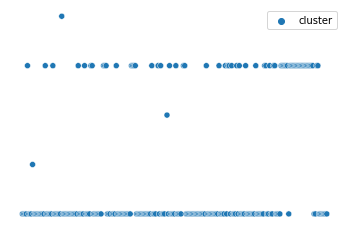

In [ ]:
# convert the prediction dataframe to a pandas dataframe
predictions_pd = prediction.toPandas()

# plot the clusters using a scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=predictions_pd[predictions_pd.cluster.isin(range(5))])
plt.axis('off')
plt.show()